In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap

from warnings import filterwarnings
filterwarnings('ignore')

## Задача: применить kernel trick, который позволит логистической регрессии достигнуть точности не менее 85%.

In [ ]:
train_url = 'https://raw.githubusercontent.com/Katalinach/ML-Datasets/master/spiral_train.txt?token=ANTWLADQF2DII7FHUYYUBIK7GRSPK'
test_url = 'https://raw.githubusercontent.com/Katalinach/ML-Datasets/master/spiral_test.txt?token=ANTWLADRNZ57DXW5H3TVU4K7GRSK6'
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

In [ ]:
# возьмем датасет целиком

size = train_df.shape[0]
df = pd.concat([train_df, test_df], axis=0).drop(['Unnamed: 0'], axis=1)

In [ ]:
df.head()

,x,y,class
0,-1.890865,0.175447,1
1,2.178012,-1.658170,2
2,-0.947198,-1.234396,2
3,-2.080490,1.001610,1
4,0.562667,1.523416,0


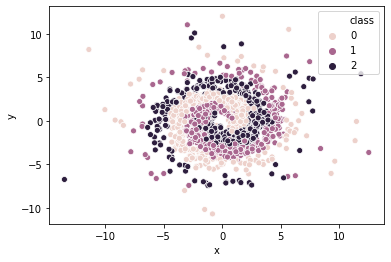

In [ ]:
# посмотрим распределение классов на графике

sns.scatterplot(x=df['x'], y=df['y'], hue='class', data=df);

In [ ]:
# применим логистическую регрессию

logreg = LogisticRegression()
logreg.fit(df.iloc[:size, :-1], df.iloc[:size, -1])
print(logreg.score(df.iloc[:-size, :-1], df.iloc[:-size, -1]))

0.388


In [ ]:
# применим SVM

svm_model = SVC()
svm_model.fit(df.iloc[:size, :-1], df.iloc[:size, -1])
print(svm_model.score(df.iloc[:-size, :-1], df.iloc[:-size, -1]))

0.794


In [ ]:
# применим к датасету kernel Isomap

isomap = Isomap(n_neighbors=5, n_components=10, n_jobs=4)
X_train_iso = isomap.fit_transform(df.iloc[:size, :-1])
X_test_iso = isomap.transform(df.iloc[:-size, :-1])

# проверим размер новых данных

print(X_train_iso.shape, X_test_iso.shape)

(1000, 10) (500, 10)


In [ ]:
# применим логистическую регрессию

logreg.fit(X_train_iso, df.iloc[:size, -1])
print(logreg.score(X_test_iso, df.iloc[:-size, -1]))

0.558


In [ ]:
# применим SVM

svm_model = SVC()
svm_model.fit(X_train_iso, df.iloc[:size, -1])
print(svm_model.score(X_test_iso, df.iloc[:-size, -1]))

0.81


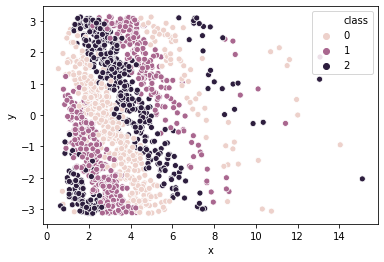

In [ ]:
# перейдем от декартовых координат к полярным

rho = np.sqrt(df['x']**2 + df['y']**2)
phi = np.arctan2(df['x'], df['y'])

new_df = pd.concat([rho, phi], axis=1)
new_df.columns = ['x', 'y']

sns.scatterplot(x=new_df['x'], y=new_df['y'], hue='class', data=df);

In [ ]:
# применим к датасету kernel Isomap

isomap = Isomap(n_neighbors=5, n_components=10, n_jobs=4)
X_train_isomap = isomap.fit_transform(new_df.iloc[:size, :])
X_test_isomap = isomap.transform(new_df.iloc[:-size, :])

# проверим размер новых данных

print(X_train_isomap.shape, X_test_isomap.shape)

(1000, 10) (500, 10)


In [ ]:
# применим логистическую регрессию к новому датасету

logreg = LogisticRegression()
logreg.fit(X_train_isomap, df.iloc[:size, -1])
print(logreg.score(X_test_isomap, df.iloc[:-size, -1]))

# при небольших значениях n_neighbors и n_components получается низкий score

0.692


In [ ]:
# увеличим значения n_neighbors и n_components

isomap_2 = Isomap(n_neighbors=30, n_components=100, n_jobs=4)
X_train_isomap_2 = isomap_2.fit_transform(new_df.iloc[:size, :])
X_test_isomap_2 = isomap_2.transform(new_df.iloc[:-size, :])

In [ ]:
# применим логистическую регрессию с заданными параметрами

logreg = LogisticRegression(solver='lbfgs', C=30)
logreg.fit(X_train_isomap_2, df.iloc[:size, -1])
print(logreg.score(X_test_isomap_2, df.iloc[:-size, -1]))

0.874


In [ ]:
# применим SVM с GridSearch

gs_isomap = GridSearchCV(
    svm_model,
    param_grid={
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': np.logspace(0.1, 1.1, 100) * 0.1
      },
      cv=5,
      scoring='accuracy'
    )

gs_isomap.fit(X_train_isomap_2, df.iloc[:size, -1])
print(gs_isomap.best_params_)

svm_model = SVC(**gs_isomap.best_params_)
svm_model.fit(X_train_isomap_2, df.iloc[:size, -1])
print(svm_model.score(X_test_isomap_2, df.iloc[:-size, -1]))

{'C': 1.1207143930292756, 'kernel': 'rbf'}
0.914
